In [2]:
#MLD adjustment applied on profiles dataset coming from NN_training.py
#date : February 2022
#author : Etienne Pauthenet (etienne.pauthenet@gmail.com)
import xarray as xr
import gsw
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
osnet_rep = ''
ds  = xr.open_dataset(osnet_rep + 'full_ds.nc').load()
ds = ds.assign_coords(N_PROF=np.arange(1,len(ds.LONGITUDE)+1))

In [3]:
@guvectorize(
    "(float64[:], float64[:], float64[:], float64[:], float64[:], float64[:])",
    "(n), (n), (n), (n) -> (n), (n)"
)
def MLD_adj_1d(temp_in, psal_in, depth, mask, temp, psal):
    temp[:] = np.copy(temp_in)
    psal[:] = np.copy(psal_in)
    for d in range(len(depth)-2, -1, -1):
        # apply mask on TEMP and PSAL
        temp[d] = (temp_in[d]*mask[d] - temp_in[d+1]*mask[d]) + temp[d+1]
        psal[d] = (psal_in[d]*mask[d] - psal_in[d+1]*mask[d]) + psal[d+1]

def MLD_adj(ds,mask):
    temp_out, psal_out = xr.apply_ufunc(MLD_adj_1d,
                                    ds['TEMP_predicted'], ds['PSAL_predicted'], ds['PRES_INTERPOLATED'], mask,
                                    input_core_dims=(['PRES_INTERPOLATED'],['PRES_INTERPOLATED'],['PRES_INTERPOLATED'],['PRES_INTERPOLATED']),
                                    output_core_dims=(['PRES_INTERPOLATED'],['PRES_INTERPOLATED']),
                                    output_dtypes=[np.float64, np.float64])
    # get sig adjusted
    sa_out = gsw.SA_from_SP(psal_out, ds['PRES_INTERPOLATED'], ds['LONGITUDE'], ds['LATITUDE'])
    ct_out = gsw.CT_from_t(sa_out,temp_out,ds['PRES_INTERPOLATED'])
    sig_out = gsw.sigma0(sa_out, ct_out)
    
    ds_out = ds.assign(variables={"TEMP_adj": (('N_PROF', 'PRES_INTERPOLATED'), temp_out.data),
                                  "PSAL_adj": (('N_PROF', 'PRES_INTERPOLATED'), psal_out.data),
                                  "SIG_adj": (('N_PROF', 'PRES_INTERPOLATED'), sig_out.data)})
    return ds_out

In [29]:
#Run with the H that gives a minimum SST abs error
b = 2
b2 = 1
H = 0.5664     #For OSnet Gulf Stream
mask2 = np.where(ds['MLD_mask'].data<H, ds['MLD_mask'], 1)
ds = ds.assign(variables={"MLD_mask2": (('N_PROF', 'PRES_INTERPOLATED'), mask2)})
mask3 = np.where((ds['MLD_mask']>H) & (ds['MLD_mask']<b2), b-ds['MLD_mask'].data, ds['MLD_mask2'].data)
ds = ds.assign(variables={"MLD_mask3": (('N_PROF', 'PRES_INTERPOLATED'), mask3)})

ds_adj05 = convective_adjustment(ds,mask = ds['MLD_mask2'])
out = convective_adjustment(ds,mask = ds['MLD_mask3']).load()


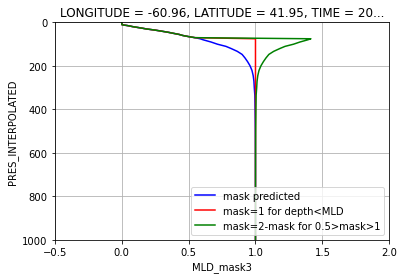

In [30]:
#Plot example 
ds.MLD_mask.isel(N_PROF = 1000).plot(y = 'PRES_INTERPOLATED',yincrease = False,label = 'mask predicted',color = 'blue')
ds.MLD_mask2.isel(N_PROF = 1000).plot(y = 'PRES_INTERPOLATED',yincrease = False,label = 'mask=1 for depth<MLD',color = 'red')
ds.MLD_mask3.isel(N_PROF = 1000).plot(y = 'PRES_INTERPOLATED',yincrease = False,label = 'mask=2-mask for 0.5>mask>1',color = 'green')
plt.grid()
plt.ylim([1000,0])
plt.xlim([-0.5,2])
plt.legend(loc = 'lower right')

In [31]:
out.to_netcdf(osnet_rep + 'full_ds_adj.nc')